# Compatability with transitleastsquares
The transitleastsquares module (Michael Hippke & René Heller 2019) can be called as an option through the BLS functionality. The transitleastsquares module has been configured to use the same input object as BLS, and additional parameters can be specified through the pars attribute. Note that these will override the default fixing of the duration grid.

## Searching the Synthetic Light-Curve
TLS is called with the tls function rather than the bls_pulse function. The synthetic light curve uses parameters very similar to the pytfit5_example notebook; the period, T0, snr and depth are occasionally modified to highlight a specific goal/purpose, which wil be discussed. 

In [1]:
import os
import numpy as np
homedir = os.getcwd()
import pytfit5.bls_cpu as gbls
import pytfit5.transitPy5 as tpy5
from pytfit5.synthetic import generate_synthetic_lightcurve

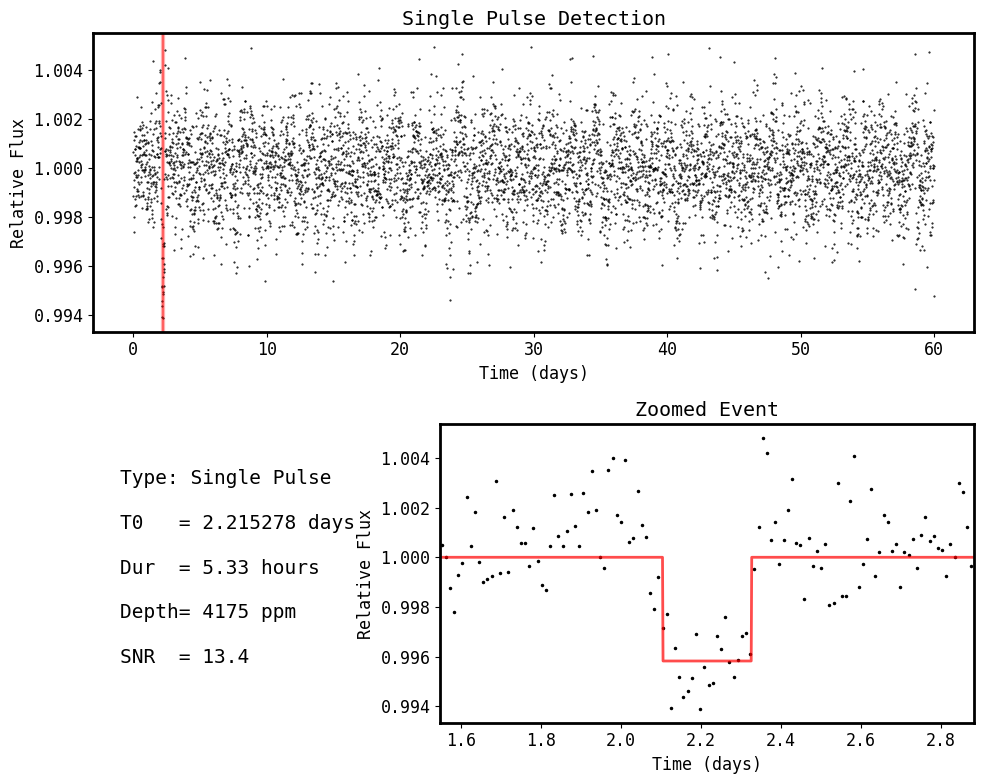

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 48 durations
Searching 5760 data points, 6636 periods from 0.601 to 59.99 days
Using all 20 CPU threads


100%|██████████| 6636/6636 periods | 00:12<00:00


{'M_star': np.float64(1.0),
 'M_star_max': np.float64(1.2),
 'M_star_min': np.float64(0.19999999999999996),
 'R_star': np.float64(1.0),
 'R_star_max': np.float64(1.2),
 'R_star_min': np.float64(0.19999999999999996),
 'n_transits_min': 1,
 'period_min': 0.5,
 'u': [0.4804, 0.1867]}


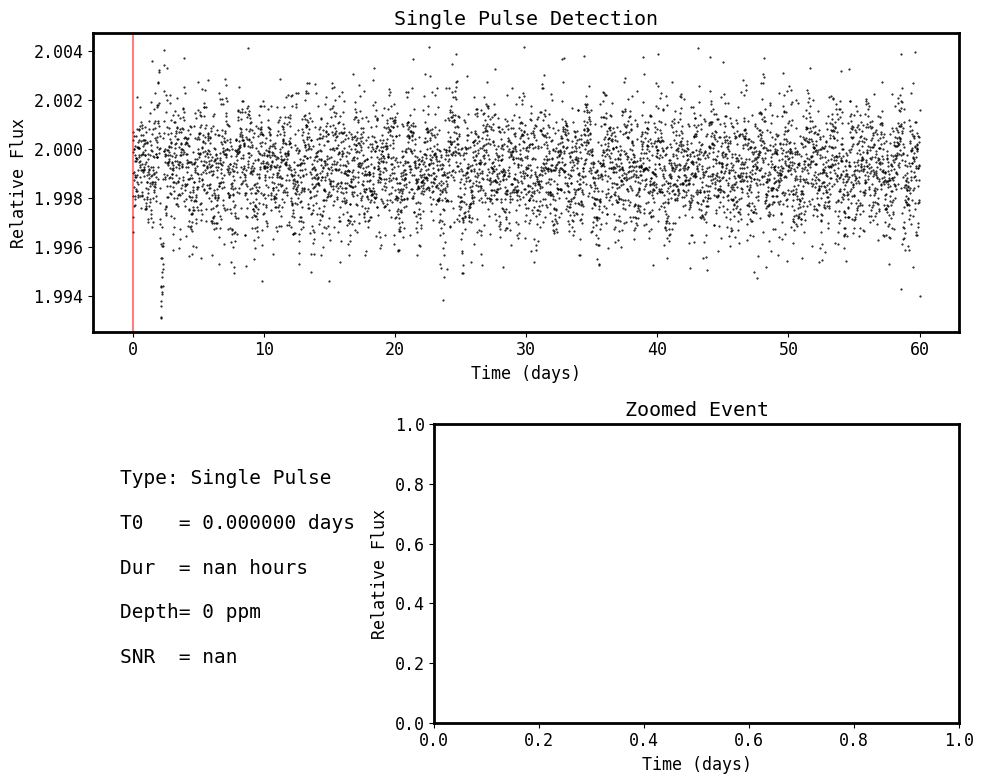

In [3]:
# Only the period is changed from the pytfit5 notebook - 10 days longer.
phot_syn, sol_injected = generate_synthetic_lightcurve(
    t0=2.2, per=66.05, time_length=60.0, depth=0.005, \
    snr=20.0, cadence=1.0/96.0, stellar_noise_type='multi', \
    stellar_noise_amplitude=0.005, rotation_period=None, seed=42)

# Configuring BLS and TLS for the synthetic data
# Removing those which are set by default appropriately, e.g zerotime, stellar parameters, etc.
syn_inputs = tpy5.tpy5_inputs_class()
syn_inputs.freq1 = 1.0 / (np.max(phot_syn.time) - np.min(phot_syn.time))  # longest period = baseline
syn_inputs.freq2 = 2.0  # c/d
syn_inputs.filename = "BLS_Synthetic"
# Data-processing is changed to 3 days detrending instead of the usual two.
syn_inputs.boxbin = 3.0  # set detrending length
syn_inputs.search_verbose  = True # for tls to spit out its parameters and search info
tpy5.run_polyfilter_iterative(phot_syn, syn_inputs)   # flux_f will contain filtered photometry

# Run Combined BLS + Pulse Search
bsyn = gbls.bls_pulse(syn_inputs, phot_syn.time, phot_syn.flux_f)
# Run TLS for a comparison to BLS
tsyn = gbls.tls(syn_inputs, phot_syn.time, phot_syn.flux_f)

## Considerations for transitleastsquares
Because TLS does not use phase-binning, it requires the errors of the flux in order to best fit the data. By adding the error as weights, TLS can now successfully detect the transits. It is also not configured to detect a singular transit or a pulse.

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 48 durations
Searching 5760 data points, 6636 periods from 0.601 to 59.99 days
Using all 20 CPU threads


100%|██████████| 6636/6636 periods | 00:12<00:00


Searching for best T0 for period 16.04429 days


100%|██████████| 5760/5760 [00:00<00:00, 6557.70it/s]


{'M_star': np.float64(1.0),
 'M_star_max': np.float64(1.2),
 'M_star_min': np.float64(0.19999999999999996),
 'R_star': np.float64(1.0),
 'R_star_max': np.float64(1.2),
 'R_star_min': np.float64(0.19999999999999996),
 'n_transits_min': 1,
 'period_min': 0.5,
 'u': [0.4804, 0.1867]}


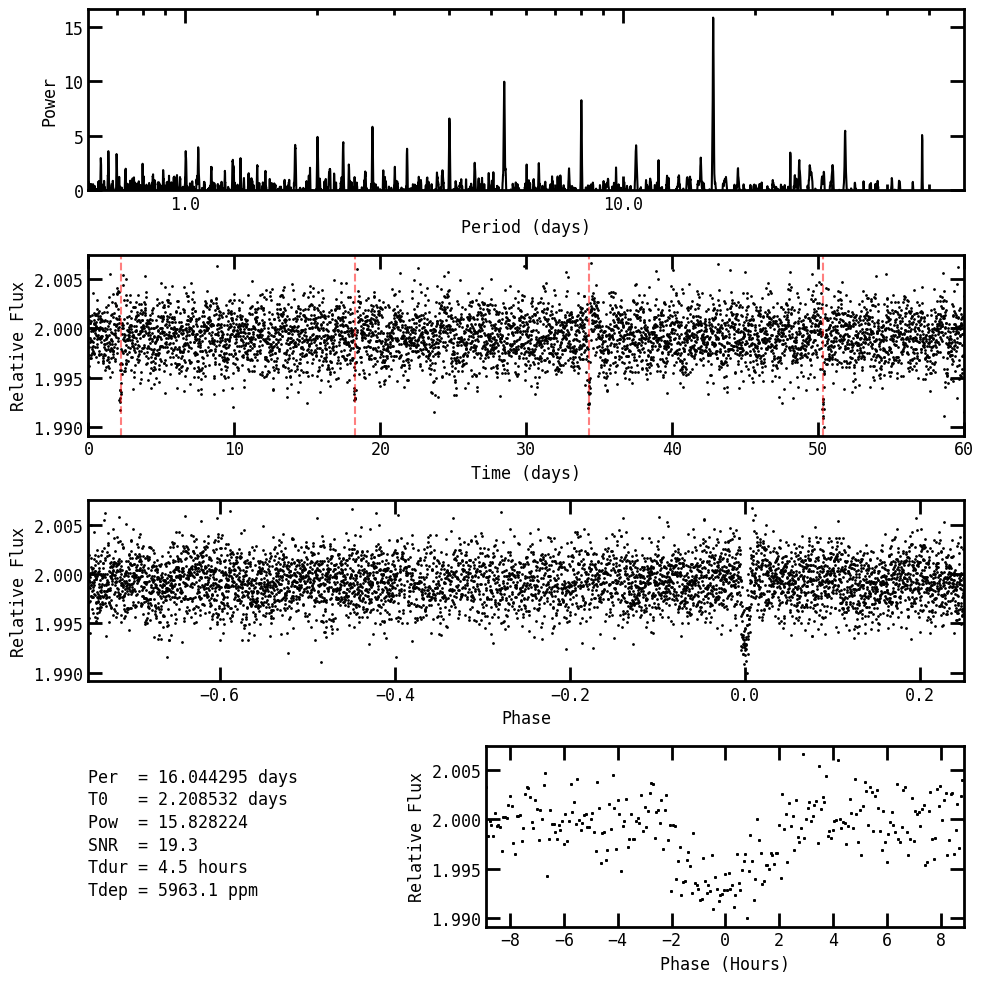

In [5]:
# Changing the period to shorter for easier detection by TLS.
phot_syn, sol_injected = generate_synthetic_lightcurve(
    t0=2.2, per=16.05, time_length=60.0, depth=0.005, \
    snr=20.0, cadence=1.0/96.0, stellar_noise_type='multi', \
    stellar_noise_amplitude=0.005, rotation_period=None, seed=42)
tpy5.run_polyfilter_iterative(phot_syn, syn_inputs)
tsyn = gbls.tls(syn_inputs, phot_syn.time, phot_syn.flux_f, phot_syn.ferr)